# Eksploracja Danych - Projekt
Tomasz Kiljańczyk (136257)

Wojciech Lulek (136280)

# Załadowanie bibliotek i danych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

data_dir = './data'

In [2]:
us_trending_df = pd.read_csv(os.path.join(data_dir, 'USData80.csv'), encoding='cp1250', lineterminator='\n')
us_trending_df = us_trending_df.iloc[: , 1:]
us_trending_df = us_trending_df.rename(columns={'description\r': 'description'})
us_trending_df['description'] = us_trending_df['description'].str.rstrip('\r')
us_trending_df

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,NaN,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ? http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20.0,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,NaN,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,NaN,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL ? http://bit.ly/subscribe-xxl...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,NaN,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115386,6WUxgmMDts4,"Blowing up Capacitors at 187,000FPS",2022-03-01T12:20:37Z,UCUK0HBIBWgM2c4vsPhkYY4w,The Slow Mo Guys,NaN,2022-03-07T00:00:00Z,slomo|slow|mo|super|motion|Slow Motion|1000|10...,981279,70153,0,3845,https://i.ytimg.com/vi/6WUxgmMDts4/default.jpg,False,False,Gav and Dan overload some capacitors and film ...
115387,6-aGt23ytyI,Most Extreme Sports!,2022-02-28T21:00:02Z,UCUaT_39o1x6qWjz7K2pWcgw,Beast Reacts,NaN,2022-03-07T00:00:00Z,life hacks|crafts|slime|do it yourself|diy|lif...,7810455,288862,0,8338,https://i.ytimg.com/vi/6-aGt23ytyI/default.jpg,False,False,Like normal sports but EXTREME!CHECK OUT THESE...
115388,vPgrkl7lEjU,The Batman - Movie Review,2022-02-28T17:00:39Z,UCCqEeDAUf4Mg0GgEN658tkA,Chris Stuckmann,NaN,2022-03-07T00:00:00Z,The Batman|Reviews|Movie Review|Chris Stuckman...,1428477,79929,0,5672,https://i.ytimg.com/vi/vPgrkl7lEjU/default.jpg,False,False,The Shelby Oaks Kickstarter is LIVE: https://w...
115389,6Svr8l1DwTc,which enderman will survive?,2022-03-01T17:00:04Z,UCh529hRsYvu9_Scri20NsHg,Spider,NaN,2022-03-07T00:00:00Z,[None],1378788,8789,0,83,https://i.ytimg.com/vi/6Svr8l1DwTc/default.jpg,False,False,#minecraft #meme #memes


# Analiza danych

## Analiza wstępna

In [3]:
us_trending_df.shape

(115391, 16)

In [4]:
us_trending_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115391 entries, 0 to 115390
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   video_id           115391 non-null  object 
 1   title              115391 non-null  object 
 2   publishedAt        115391 non-null  object 
 3   channelId          115391 non-null  object 
 4   channelTitle       115391 non-null  object 
 5   categoryId         23027 non-null   float64
 6   trending_date      115391 non-null  object 
 7   tags               115391 non-null  object 
 8   view_count         115391 non-null  int64  
 9   likes              115391 non-null  int64  
 10  dislikes           115391 non-null  int64  
 11  comment_count      115391 non-null  int64  
 12  thumbnail_link     115391 non-null  object 
 13  comments_disabled  115391 non-null  bool   
 14  ratings_disabled   115391 non-null  bool   
 15  description        115391 non-null  object 
dtypes:

CategoryId zawiera NaNy, trzeba się ich pozbyć

In [5]:
us_trending_df['categoryId'].replace(np.NaN, 0.0, inplace=True)

CategoryId jest typu float64. Żeby zamienić je na stringa trzeba je zmienić wpierw na int64

In [6]:
us_trending_df['categoryId'] = us_trending_df['categoryId'].astype(np.int64)

Kolumny opisujące daty są typu object.
Można je zrzutować na typ datetime64.
categoryId należy zrzutować na typ string, ponieważ nie chcemy go traktować jako dane numeryczne.

In [7]:
us_trending_df = us_trending_df.astype({
    'trending_date': np.datetime64,
    'publishedAt': np.datetime64,
    'categoryId': str
})
us_trending_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115391 entries, 0 to 115390
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   video_id           115391 non-null  object        
 1   title              115391 non-null  object        
 2   publishedAt        115391 non-null  datetime64[ns]
 3   channelId          115391 non-null  object        
 4   channelTitle       115391 non-null  object        
 5   categoryId         115391 non-null  object        
 6   trending_date      115391 non-null  datetime64[ns]
 7   tags               115391 non-null  object        
 8   view_count         115391 non-null  int64         
 9   likes              115391 non-null  int64         
 10  dislikes           115391 non-null  int64         
 11  comment_count      115391 non-null  int64         
 12  thumbnail_link     115391 non-null  object        
 13  comments_disabled  115391 non-null  bool    

W kolumnie description występują brakujące wartości.
Można by je uzupełnić pustym stringiem albo spacją.

In [8]:
us_trending_df['description'].replace(np.NaN, '', inplace=True)
us_trending_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115391 entries, 0 to 115390
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   video_id           115391 non-null  object        
 1   title              115391 non-null  object        
 2   publishedAt        115391 non-null  datetime64[ns]
 3   channelId          115391 non-null  object        
 4   channelTitle       115391 non-null  object        
 5   categoryId         115391 non-null  object        
 6   trending_date      115391 non-null  datetime64[ns]
 7   tags               115391 non-null  object        
 8   view_count         115391 non-null  int64         
 9   likes              115391 non-null  int64         
 10  dislikes           115391 non-null  int64         
 11  comment_count      115391 non-null  int64         
 12  thumbnail_link     115391 non-null  object        
 13  comments_disabled  115391 non-null  bool    

Przy ręcznej analizie znaleziono też tagi `[None]`.
Chyba najlepiej zamienić je na pusty string.

In [9]:
us_trending_df['tags'].replace('[None]', '', inplace=True)

In [10]:
us_trending_df.nunique()

video_id              20831
title                 21284
publishedAt           20514
channelId              5238
channelTitle           5322
categoryId               16
trending_date           557
tags                  15343
view_count           112973
likes                 84931
dislikes              13179
comment_count         27202
thumbnail_link        20831
comments_disabled         2
ratings_disabled          2
description           21309
dtype: int64

W policzonych unikatowych wartościach widać, że unikatowych wartości video_id jest mniej niż ilość wszystkich rzędów w pliku.

Wynika to z faktu, że w danych znajdują się zrzuty listy trending z wielu dni.
Jeden filmik mógł być trending przez parę dni.

## Wizualizacje

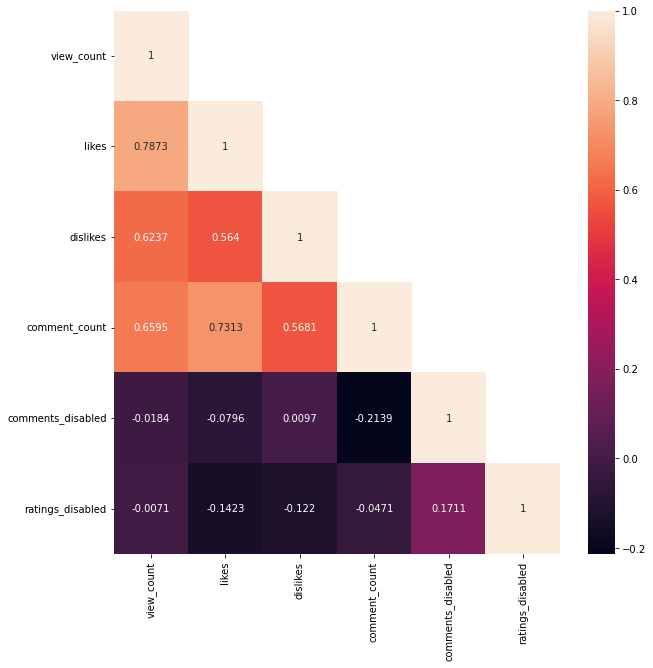

In [11]:
corrMatrix = us_trending_df.corr(method='spearman')
corrMatrix = corrMatrix.round(4)

mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
np.fill_diagonal(mask, False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrMatrix, mask=mask, annot=True, fmt='g', ax=ax)
plt.show()

Używamy metryki Spearmana, ponieważ to umożliwia odkrycie nieliniowych zależności między cechami.

Zależności większe niż |0.5|:
* view_count:
    * comment_count
    * dislikes
    * likes
* likes:
    * comment_count
    * dislikes
* dislikes:
    * comment_count

Z wypisanych zależności wynika, że im więcej osób ogląda filmik, tym więcej jest komentarzy, polubień i antypolubień.
To jest logiczna konsekwencja wpływu oglądalności na te cechy.

<AxesSubplot:>

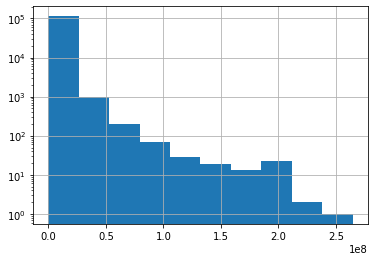

In [12]:
us_trending_df['view_count'].hist(log=True)

<AxesSubplot:>

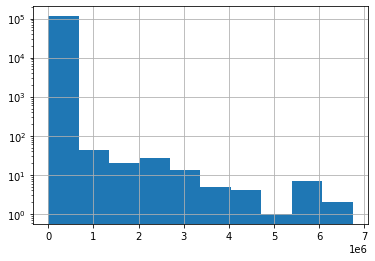

In [13]:
us_trending_df['comment_count'].hist(log=True)

<AxesSubplot:>

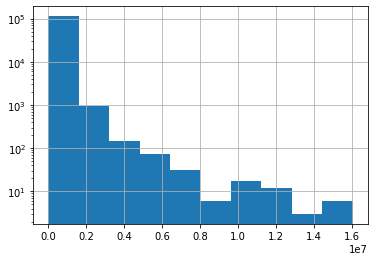

In [14]:
us_trending_df['likes'].hist(log=True)

<AxesSubplot:>

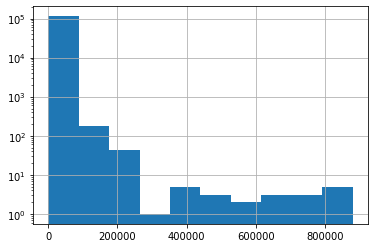

In [15]:
us_trending_df['dislikes'].hist(log=True)

## Analiza kategorii

In [16]:
import json

with open(os.path.join(data_dir,'US_category_id.json'), mode='r') as file:
    us_category_id_dict = json.loads(file.read())

us_categories = {}
for category in us_category_id_dict['items']:
    us_categories[category['id']] = category['snippet']['title']

us_categories

{'1': 'Film & Animation',
 '2': 'Autos & Vehicles',
 '10': 'Music',
 '15': 'Pets & Animals',
 '17': 'Sports',
 '18': 'Short Movies',
 '19': 'Travel & Events',
 '20': 'Gaming',
 '21': 'Videoblogging',
 '22': 'People & Blogs',
 '23': 'Comedy',
 '24': 'Entertainment',
 '25': 'News & Politics',
 '26': 'Howto & Style',
 '27': 'Education',
 '28': 'Science & Technology',
 '29': 'Nonprofits & Activism',
 '30': 'Movies',
 '31': 'Anime/Animation',
 '32': 'Action/Adventure',
 '33': 'Classics',
 '34': 'Comedy',
 '35': 'Documentary',
 '36': 'Drama',
 '37': 'Family',
 '38': 'Foreign',
 '39': 'Horror',
 '40': 'Sci-Fi/Fantasy',
 '41': 'Thriller',
 '42': 'Shorts',
 '43': 'Shows',
 '44': 'Trailers'}

In [17]:
len(us_categories)

32

Z analizy wynika, że używane jest 15 kategorii, a w pliku JSON dostarczone zostało 32 kategorie.
17 kategorii jest nieużywanych.

In [18]:
us_trending_df['category'] = us_trending_df['categoryId']
us_trending_df['category'] = us_trending_df['category'].apply(us_categories.get).replace(np.NaN, '')
us_trending_df['category']

0               
1         Gaming
2               
3               
4               
           ...  
115386          
115387          
115388          
115389          
115390          
Name: category, Length: 115391, dtype: object

In [19]:
category_counts = us_trending_df.groupby(["category"]).size().reset_index(name='counts')
category_counts

,category,counts
0,,92364
1,Autos & Vehicles,359
2,Comedy,1305
3,Education,534
4,Entertainment,4553
5,Film & Animation,1016
6,Gaming,4030
7,Howto & Style,760
8,Music,4116
9,News & Politics,894


<AxesSubplot:xlabel='category'>

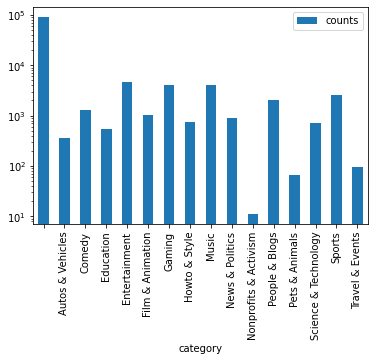

In [20]:
category_counts.plot(x='category', y='counts', kind='bar', logy=True)

## Analiza tytułów

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(strip_accents='unicode', stop_words='english')

In [22]:
titles_vectorized_csr = vectorizer.fit_transform(us_trending_df['title'])
token_count_sum = titles_vectorized_csr.sum(axis=0).A1
tokens = vectorizer.get_feature_names_out()
df_dict = {'token': tokens, 'count': token_count_sum}
token_count_df = pd.DataFrame(df_dict)
token_count_df

,token,count
0,00,22
1,000,1988
2,0000001,5
3,000cal,6
4,000fps,24
...,...,...
17778,zouma,3
17779,zuko,11
17780,zverev,8
17781,zy,4


In [23]:
top_words = token_count_df.sort_values(by=['count'], ascending=False).head(100).reset_index(drop=True)
print(top_words.to_string())

         token  count
0     official  14667
1        video  12985
2           vs   6268
3    minecraft   5261
4        music   4751
5         2021   4669
6      trailer   4610
7   highlights   4476
8       shorts   4073
9          new   3879
10        game   3223
11          ft   3152
12        2020   2792
13      season   2150
14         lil   2086
15       world   2013
16         000   1988
17        feat   1957
18         day   1810
19        live   1802
20        life   1692
21    fortnite   1640
22          10   1519
23     episode   1501
24         nba   1500
25        best   1488
26        baby   1479
27       audio   1476
28         100   1470
29   challenge   1363
30     oficial   1351
31       house   1303
32        home   1245
33       night   1238
34         got   1203
35      teaser   1182
36      sports   1155
37        time   1146
38         man   1120
39       dream   1103
40      reacts   1087
41      update   1073
42         nfl   1048
43      reveal   1035
44        

Notatka:
* Można wpisać słowa jako cechy i potem usuwać metodami z wykładu
* Przydałby się ranking informatywności.
* Można użyć słownika z kategoriami

## Analiza tagów

In [24]:
vectorizer = CountVectorizer(strip_accents='unicode', token_pattern=r'[^|]+')

In [25]:
tags_vectorized_csr = vectorizer.fit_transform(us_trending_df['tags'])
token_count_sum = tags_vectorized_csr.sum(axis=0).A1
tokens = vectorizer.get_feature_names_out()
df_dict = {'token': tokens, 'count': token_count_sum}
token_count_df = pd.DataFrame(df_dict)
token_count_df

,token,count
0,#shorts,31
1,#shorts,2
2,1st odi,7
3,5 guys vs 5 girls,20
4,?,51
...,...,...
117625,“golf”,7
117626,“gordon,6
117627,“raj,6
117628,“ron’s,6


In [26]:
top_tags = token_count_df.sort_values(by=['count'], ascending=False).head(100).reset_index(drop=True)
print(top_tags.to_string())

                     token  count
0                       ??  11142
1                    funny   8115
2                      ???   7397
3                minecraft   5564
4                   comedy   5235
5                challenge   3359
6                      rap   3331
7                     ????   3214
8                     vlog   2934
9                     news   2864
10                football   2854
11                   music   2749
12                 hip hop   2686
13              highlights   2648
14                  tiktok   2376
15                  gaming   2354
16               animation   2348
17                fortnite   2186
18                     nba   2160
19                  family   2111
20                  sports   2066
21                   ?????   1934
22         family friendly   1888
23                     new   1888
24                  how to   1801
25                reaction   1731
26                   video   1696
27                 trailer   1661
28            

# Inne atrybuty

## Nowe atrybuty na podstawie atrybutów tekstowych

<AxesSubplot:>

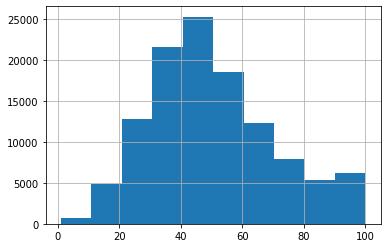

In [27]:
us_trending_df['title_length'] = us_trending_df['title'].str.len()
us_trending_df['title_length'].hist()

<AxesSubplot:>

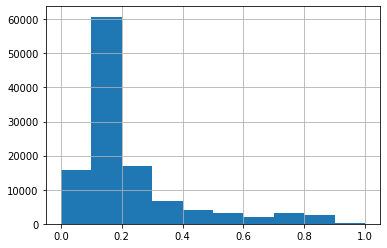

In [28]:
us_trending_df['title_capital_letters'] = us_trending_df['title'].str.count(r'[A-Z]') / us_trending_df['title_length']
us_trending_df['title_capital_letters'].hist()

<AxesSubplot:>

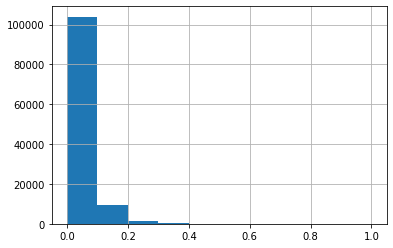

In [29]:
us_trending_df['title_punctuaction'] = us_trending_df['title'].str.count(r'[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]') / us_trending_df['title_length']
us_trending_df['title_punctuaction'].hist()

<AxesSubplot:>

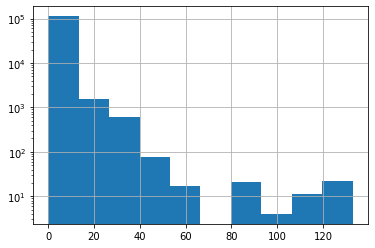

In [30]:
us_trending_df['description_height'] = us_trending_df['description'].str.count(r'[\r\n]')
us_trending_df['description_height'].hist(log=True)

<AxesSubplot:>

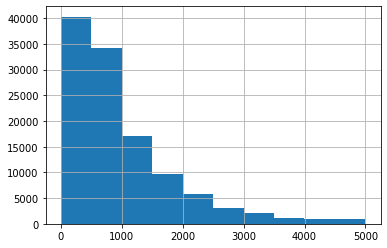

In [31]:
us_trending_df['description_length'] = us_trending_df['description'].str.len()
us_trending_df['description_length'].hist()

<AxesSubplot:>

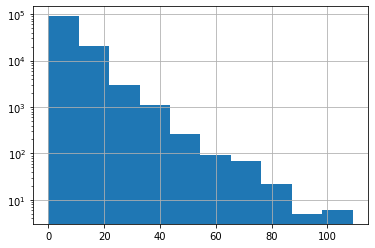

In [32]:
us_trending_df['description_link_count'] = us_trending_df['description'].str.count(r'://')
us_trending_df['description_link_count'].hist(log=True)

Notatka: można podzielić linki na kategorie

<AxesSubplot:>

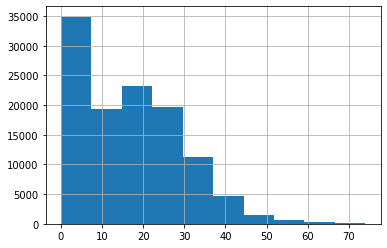

In [33]:
us_trending_df['tag_count'] = us_trending_df['tags'].apply(lambda tags: 0 if tags == '' else tags.count('|') + 1)
us_trending_df['tag_count'].hist()

## Nowe atrybuty na podstawie dat

<AxesSubplot:>

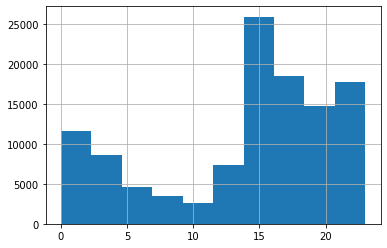

In [34]:
us_trending_df['publishedAtHour'] = us_trending_df['publishedAt'].dt.hour
us_trending_df['publishedAtHour'].hist()

<AxesSubplot:>

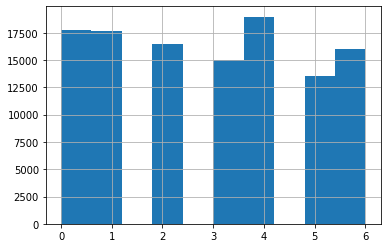

In [35]:
us_trending_df['publishedAtDay'] = us_trending_df['publishedAt'].dt.weekday
us_trending_df['publishedAtDay'].hist() 

<AxesSubplot:>

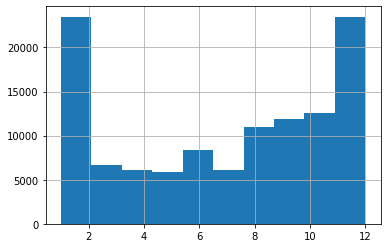

In [36]:
us_trending_df['publishedAtMonth'] = us_trending_df['publishedAt'].dt.month
us_trending_df['publishedAtMonth'].hist()

Notatka:
* Warto się przyjrzeć miesiącom publikacji

In [37]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
min_date = us_trending_df['publishedAt'].min()
max_date = us_trending_df['publishedAt'].max()

holidays = cal.holidays(start=min_date, end=max_date)
us_trending_df['publishedAtHoliday'] = us_trending_df['publishedAt'].apply(lambda date: date in holidays)
us_trending_df[us_trending_df['publishedAtHoliday']]

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,...,title_capital_letters,title_punctuaction,description_height,description_length,description_link_count,tag_count,publishedAtHour,publishedAtDay,publishedAtMonth,publishedAtHoliday


Filmiki z listy trending nie były publikowane z święta.

Notatka:
* można spróbować dzień przed/po świętach

Notatka końcowa:
* Warto sprawdzić rozkłady dla różnych kategorii filmików

# Usuwanie kolumn

In [38]:
us_trending_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115391 entries, 0 to 115390
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   video_id                115391 non-null  object        
 1   title                   115391 non-null  object        
 2   publishedAt             115391 non-null  datetime64[ns]
 3   channelId               115391 non-null  object        
 4   channelTitle            115391 non-null  object        
 5   categoryId              115391 non-null  object        
 6   trending_date           115391 non-null  datetime64[ns]
 7   tags                    115391 non-null  object        
 8   view_count              115391 non-null  int64         
 9   likes                   115391 non-null  int64         
 10  dislikes                115391 non-null  int64         
 11  comment_count           115391 non-null  int64         
 12  thumbnail_link          115391

* Nie da się wykorzystać
  * Nieprzetworzonych tagów
  * Nieprzetworzonych opisów
  * Nieprzetworzonych tytułów
  * video_id
  * channelId - niekoniecznie
  * channelTitle - niekoniecznie
  * trending_date, bo niewystępuje w danych nie-trending
  * nieprzetworzone publishedAt

* Można zamienić na coś innego:
  * likes i dislikes można zamienić na ilość reakcji i procent likes

Notatka:
* channelId/Title można użyć do sprawdzania kategorii
* Trending date może mieć znaczenie na etapie uczenia (np. w jakim miesiącu są trending).

In [39]:
us_trending_clean_df = us_trending_df.copy()
us_trending_clean_df.drop(
    [
     "video_id",
     "title",
     "publishedAt",
     "categoryId",
     "tags",
     "description"
    ], axis=1, inplace=True
)
us_trending_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115391 entries, 0 to 115390
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   channelId               115391 non-null  object        
 1   channelTitle            115391 non-null  object        
 2   trending_date           115391 non-null  datetime64[ns]
 3   view_count              115391 non-null  int64         
 4   likes                   115391 non-null  int64         
 5   dislikes                115391 non-null  int64         
 6   comment_count           115391 non-null  int64         
 7   thumbnail_link          115391 non-null  object        
 8   comments_disabled       115391 non-null  bool          
 9   ratings_disabled        115391 non-null  bool          
 10  category                115391 non-null  object        
 11  title_length            115391 non-null  int64         
 12  title_capital_letters   115391

In [40]:
us_trending_clean_df

,channelId,channelTitle,trending_date,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,...,title_capital_letters,title_punctuaction,description_height,description_length,description_link_count,tag_count,publishedAtHour,publishedAtDay,publishedAtMonth,publishedAtHoliday
0,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,2020-08-12,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,...,0.735294,0.088235,7,361,3,15,19,1,8,False
1,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,2020-08-12,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,...,0.100000,0.016667,0,715,4,25,17,1,8,False
2,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,2020-08-12,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,...,0.094340,0.018868,0,513,7,30,16,1,8,False
3,UCbg_UMjlHJg_19SZckaKajg,XXL,2020-08-12,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,...,0.142857,0.017857,5,762,6,23,16,1,8,False
4,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,2020-08-12,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,...,0.200000,0.018182,0,2493,35,33,15,1,8,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115386,UCUK0HBIBWgM2c4vsPhkYY4w,The Slow Mo Guys,2022-03-07,981279,70153,0,3845,https://i.ytimg.com/vi/6WUxgmMDts4/default.jpg,False,False,...,0.142857,0.028571,0,367,2,24,12,1,3,False
115387,UCUaT_39o1x6qWjz7K2pWcgw,Beast Reacts,2022-03-07,7810455,288862,0,8338,https://i.ytimg.com/vi/6-aGt23ytyI/default.jpg,False,False,...,0.150000,0.050000,0,2101,34,25,21,0,2,False
115388,UCCqEeDAUf4Mg0GgEN658tkA,Chris Stuckmann,2022-03-07,1428477,79929,0,5672,https://i.ytimg.com/vi/vPgrkl7lEjU/default.jpg,False,False,...,0.160000,0.040000,0,465,2,28,17,0,2,False
115389,UCh529hRsYvu9_Scri20NsHg,Spider,2022-03-07,1378788,8789,0,83,https://i.ytimg.com/vi/6Svr8l1DwTc/default.jpg,False,False,...,0.000000,0.035714,0,23,0,0,17,1,3,False


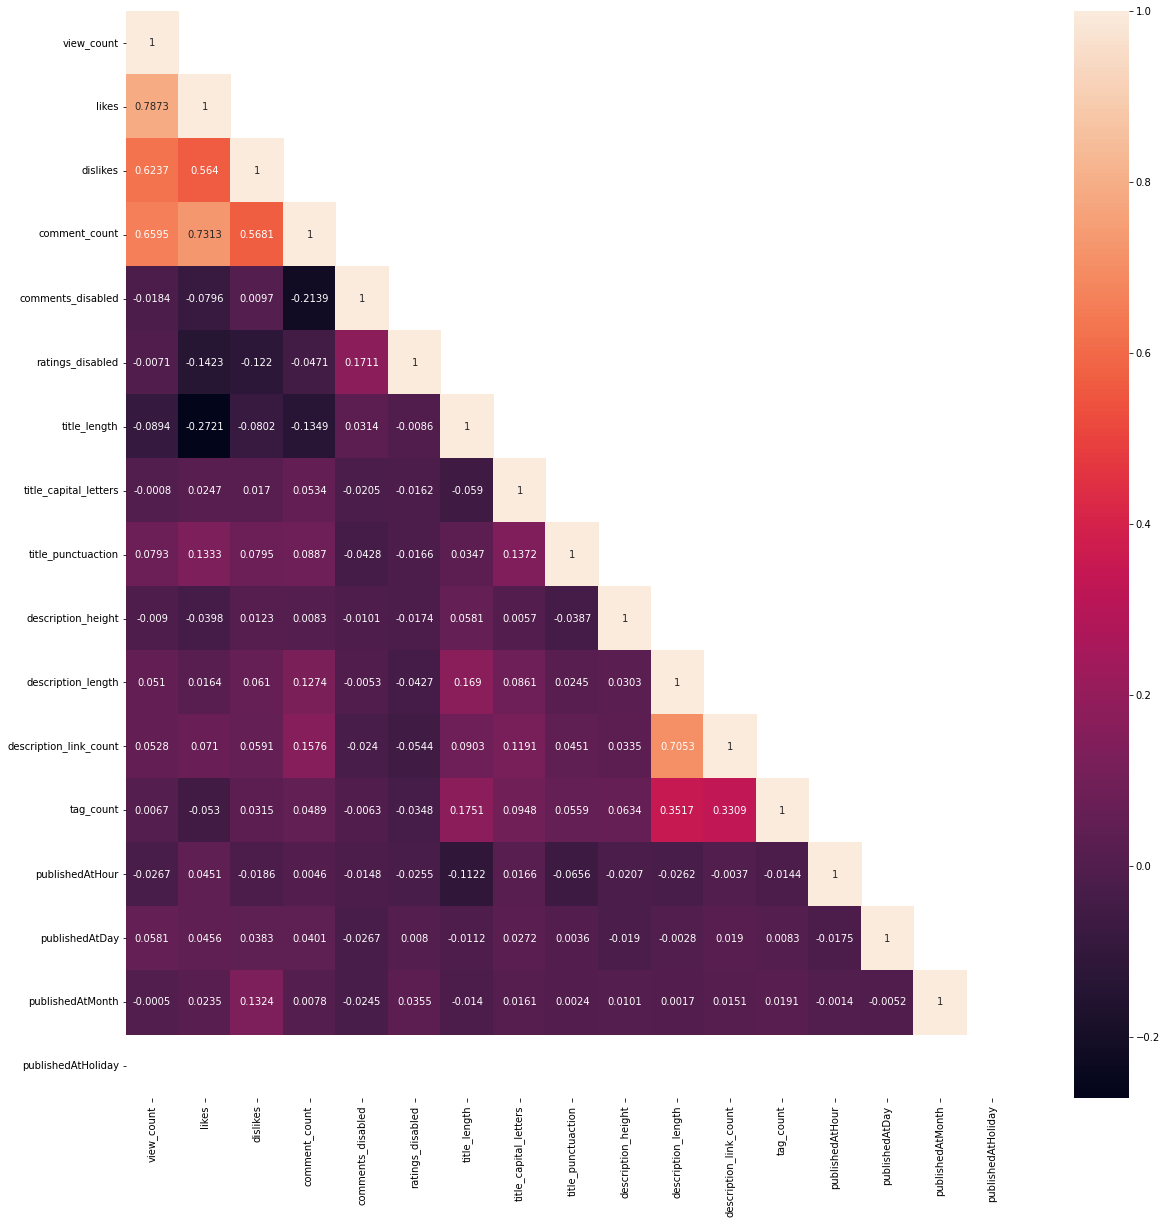

In [41]:
corrMatrix = us_trending_clean_df.corr(method='spearman')
corrMatrix = corrMatrix.round(4)

mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
np.fill_diagonal(mask, False)

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrMatrix, mask=mask, annot=True, fmt='g', ax=ax)
plt.show()

In [42]:
us_trending_clean_df.to_csv("./data/stage_1_us_trending.csv", index=False)